# Porcelain Mark Classifier
by Cheong Hao Ming

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Importing packages

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout,Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.applications as models
import keras

# Introduction

## Background

Porcelain marks on antique Chinese porcelain were used to represent the period a piece was made in. Rather than indicating a particular year, the marks are usually reign marks which suggest the item may have been made anytime during the reign of a particular emperor. Therefore these porcelain marks have always been a topic of interest for experienced and budding new collectors alike.

## Problem Statement

As a business manager of a local antique boutique store specialising in oriental porcelain, I have chosen to build a porcelain mark classifier to test and improve my understanding of computer vision while applying some domain knowledge in the field of oriental porcelain.

Given that there exist more than a few dozen types of reign marks in just the two most recent dynasties alone (Ming and Qing Dynasty), this model will be scaled down to classifying 3 different reign marks of the Qing Dynasty.

# The Data

All image data have been manually collected from the websites of reputable auctions sites such as Sotheby's and Christies to ensure authenticity and accuracy of the images used to train and test the model.

## Summary of Dataset

|   | **Period** | **Source** | **Type**   | **Train** | **Val** | **Test** |
|:-:|:----------:|:----------:|------------|:---------:|:-------:|:--------:|
| 1 |  Qianlong  |  Internet  | _Zhuanshu_ |     62    |    20   |    30    |
| 2 |  Daoguang  |  Internet  | _Zhuanshu_ |     60    |    20   |    30    |
| 3 |   Guangxu  |  Internet  | _Kaishu_   |     60    |    20   |    30    |



In [ ]:
# Defining image paths

train_path="/content/drive/MyDrive/DSI Capstone/data/train"
test_path="/content/drive/MyDrive/DSI Capstone/data/test"
val_path="/content/drive/MyDrive/DSI Capstone/data/val"
test_path_clean="/content/drive/MyDrive/DSI Capstone/data/test_clean"

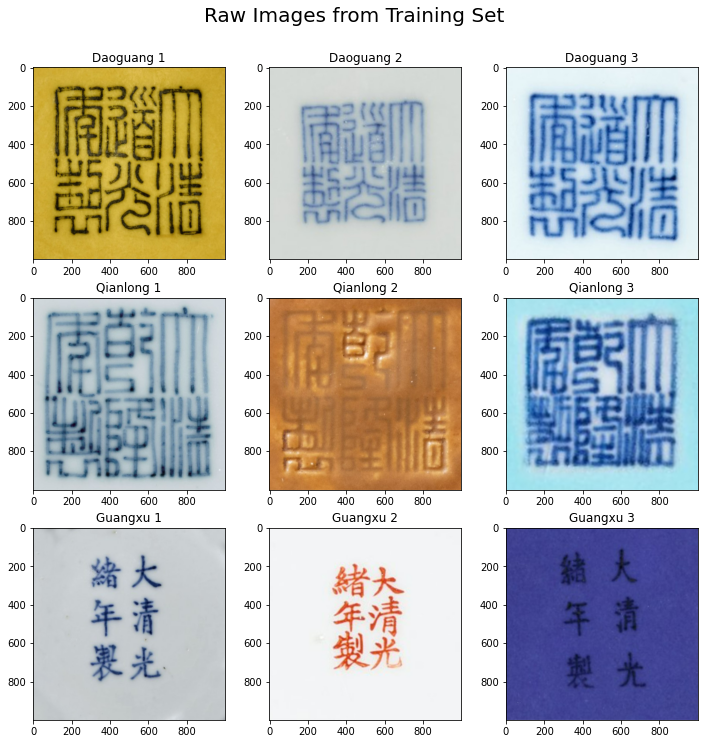

In [ ]:
# Previewing images

f, axarr = plt.subplots(nrows=3,ncols=3,figsize=(12,12))
plt.sca(axarr[0,0]); 
plt.imshow(plt.imread(train_path+"/daoguang/ (1).jpg")); plt.title('Daoguang 1')
plt.sca(axarr[0,1]); 
plt.imshow(plt.imread(train_path+"/daoguang/ (2).jpg")); plt.title('Daoguang 2')
plt.sca(axarr[0,2]); 
plt.imshow(plt.imread(train_path+"/daoguang/ (3).jpg")); plt.title('Daoguang 3')
plt.sca(axarr[1,0]); 
plt.imshow(plt.imread(train_path+"/qianlong/ (1).JPG")); plt.title('Qianlong 1')
plt.sca(axarr[1,1]); 
plt.imshow(plt.imread(train_path+"/qianlong/ (2).JPG")); plt.title('Qianlong 2')
plt.sca(axarr[1,2]); 
plt.imshow(plt.imread(train_path+"/qianlong/ (3).JPG")); plt.title('Qianlong 3')
plt.sca(axarr[2,0]); 
plt.imshow(plt.imread(train_path+"/guangxu/gx_r_001.jpg")); plt.title('Guangxu 1')
plt.sca(axarr[2,1]); 
plt.imshow(plt.imread(train_path+"/guangxu/gx_r_005.JPG")); plt.title('Guangxu 2')
plt.sca(axarr[2,2]); 
plt.imshow(plt.imread(train_path+"/guangxu/gx_r_019.JPG")); plt.title('Guangxu 3')
plt.suptitle('Raw Images from Training Set', fontsize = 20, y = 0.95)
plt.show()


The above output give a preview of the 3 different porcelain marks that the model will be attempting to classify. Both Daoguang and Qianlong porcelain mark follows the "Zhuanshu" format while the Guangxu mark adopts the "Kaishu" format. We can also observe that within a class there will be some variations as the marks were all handwritten. The different glaze (colour) of the porcelain also adds more variation to the training data.

In [ ]:
# Utilizing Keras ImageDataGenerator to conduct some augmentation to add some variance to our training data
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   rotation_range=20,
                                   zoom_range=[1,2.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode="nearest"
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range=20,
                                zoom_range=[1,2.5],
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                  fill_mode="nearest"
                                   )

In [ ]:
# Grouping the data into train, validation and test set with flow_from_directory

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 shuffle = False,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            shuffle = False,
                                            class_mode = 'categorical')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 182 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


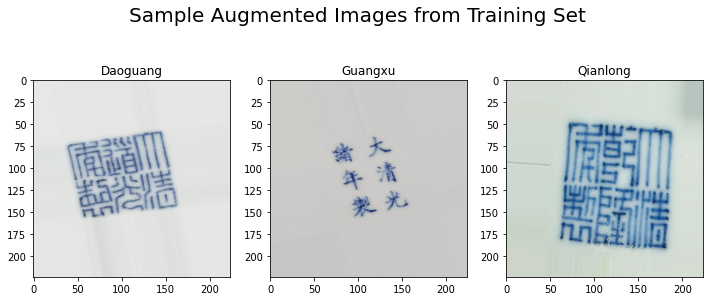

In [ ]:
#Previewing the augmented training images
f, axarr = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plt.sca(axarr[0]); 
plt.imshow(training_set[0][0][5]); plt.title('Daoguang')
plt.sca(axarr[1]); 
plt.imshow(training_set[3][0][4]); plt.title('Guangxu')
plt.sca(axarr[2]); 
plt.imshow(training_set[5][0][3]); plt.title('Qianlong')
plt.suptitle('Sample Augmented Images from Training Set', fontsize = 20, y=1.1)
plt.show()

The above output provides a preview of the possible augmented images created by the image generator. The purpose of augmenting our image is to add more variations to the training data in a bid to simulate test images that may not have been cropped and centralised properly like those in our training data.

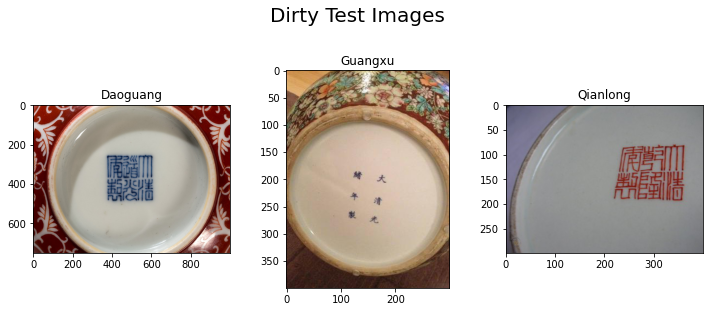

In [ ]:
# Previewing "dirty" test images
f, axarr = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plt.sca(axarr[0]); 
plt.imshow(plt.imread(test_path+"/daoguang/MT_daoguang_01.jpg")); plt.title('Daoguang')
plt.sca(axarr[1]); 
plt.imshow(plt.imread(test_path+"/guangxu/MT_guangxu_ (4).jpg")); plt.title('Guangxu')
plt.sca(axarr[2]); 
plt.imshow(plt.imread(test_path+"/qianlong/MT_qianlong_9.jpg")); plt.title('Qianlong')
plt.suptitle('Dirty Test Images', fontsize = 20, y = 1.1)
plt.show()


For each class, 10 of the 30 test images selected are "dirty" test images like those shown above. These are the typical pictures we can expect from non professional photoshoots. The image may be taken from varying distances and angle. As such, the image augmentation settings includes rotation, zoom and image shifting along the y and x axis.

# Modelling

## Callbacks

In [ ]:
from matplotlib.cbook import CallbackRegistry
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

re_adam = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 1/np.sqrt(10),
                          patience = 5,
                          cooldown =5,
                          verbose = 1,
                          min_delta = 0.01,
                          min_lr = 0.00001)

cp_cnn = ModelCheckpoint('/content/drive/MyDrive/DSI Capstone/models/cnn_model.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True, 
                             mode='max')

cp_vggb = ModelCheckpoint('/content/drive/MyDrive/DSI Capstone/models/vggb_model.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True, 
                             mode='max')

cp_vgg = ModelCheckpoint('/content/drive/MyDrive/DSI Capstone/models/vgg_model.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True, 
                             mode='max')

cp_mobileb = ModelCheckpoint('/content/drive/MyDrive/DSI Capstone/models/mobileb_model.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True,
                             mode='max') 

                             
cp_mobile = ModelCheckpoint('/content/drive/MyDrive/DSI Capstone/models/mobile_model.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = True, 
                             mode='max')

callback_cnn = [early_stop, re_adam, cp_cnn ]
callback_vggb = [early_stop, re_adam, cp_vggb ]
callback_vgg = [early_stop, re_adam, cp_vgg ]
callback_mobileb = [early_stop, re_adam, cp_mobileb ]
callback_mobile = [early_stop, re_adam, cp_mobile ]


## Custom CNN Model

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(224, 224, 3)))
    
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(128,
              activation = "relu"))
          
cnn_model.add(Dense(32,
              activation = "relu"))
          
cnn_model.add(Dense(3,
              activation = "softmax"))

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                        

In [ ]:
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
callback_cnn = [re_adam, cp_cnn]

In [ ]:
cnn_history = cnn_model.fit(training_set, 
                            batch_size=32,
                            callbacks = callback_cnn,
                            validation_data = val_set,
                            epochs=60)

Epoch 1/60
6/6 [==============================] - ETA: 0s - loss: 115.9998 - accuracy: 0.0714
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/MyDrive/DSI Capstone/models/cnn_model.h5
6/6 [==============================] - 9s 2s/step - loss: 115.9998 - accuracy: 0.0714 - val_loss: 29.5715 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/60
6/6 [==============================] - ETA: 0s - loss: 23.0797 - accuracy: 0.2418
Epoch 2: val_accuracy did not improve from 0.33333
6/6 [==============================] - 6s 961ms/step - loss: 23.0797 - accuracy: 0.2418 - val_loss: 15.4226 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/60
6/6 [==============================] - ETA: 0s - loss: 8.7972 - accuracy: 0.3736
Epoch 3: val_accuracy improved from 0.33333 to 0.35000, saving model to /content/drive/MyDrive/DSI Capstone/models/cnn_model.h5
6/6 [==============================] - 6s 1s/step - loss: 8.7972 - accuracy: 0.3736 - val_loss: 2.7957 - val_accuracy: 0.3500 - lr:

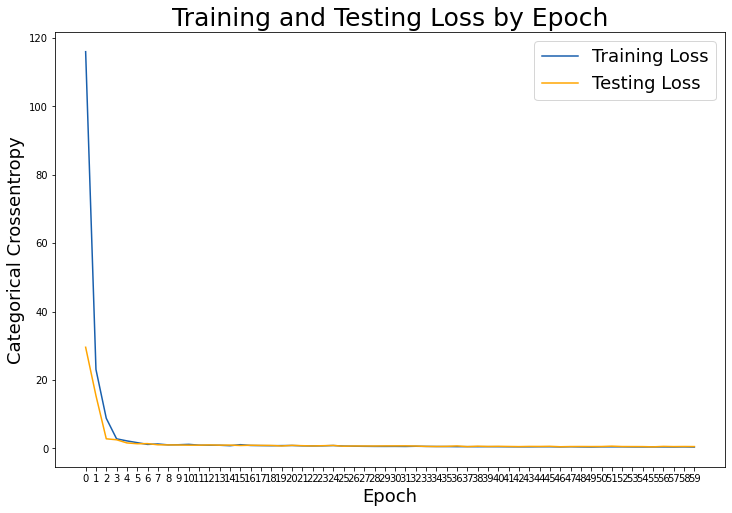

In [ ]:
train_loss = cnn_history.history['loss']
test_loss = cnn_history.history['val_loss']
epoch_labels = cnn_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

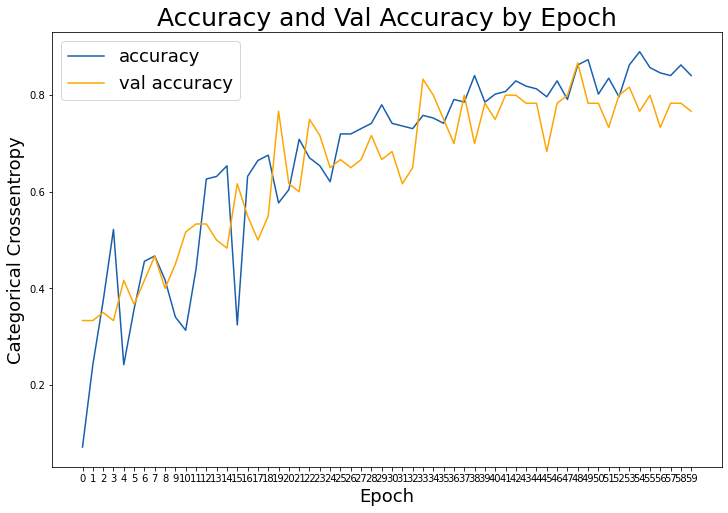

In [ ]:
train_loss = cnn_history.history['accuracy']
test_loss = cnn_history.history['val_accuracy']
epoch_labels = cnn_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='accuracy', color='#185fad')
plt.plot(test_loss, label='val accuracy', color='orange')

# Set title
plt.title('Accuracy and Val Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
cnn_model.load_weights("/content/drive/MyDrive/DSI Capstone/models/cnn_model.h5")

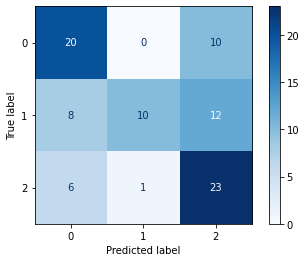

In [ ]:
cnn_preds = cnn_model.predict(test_set)
cnn_preds = np.argmax(cnn_preds,axis=1)
cnn_cm = confusion_matrix(test_set.classes, cnn_preds)
cnn_disp = ConfusionMatrixDisplay(cnn_cm);
cnn_disp.plot(cmap='Blues');

In [ ]:
cnn_model.evaluate(training_set,
                      verbose=2)

6/6 - 35s - loss: 0.4086 - accuracy: 0.8571 - 35s/epoch - 6s/step


[0.40859219431877136, 0.8571428656578064]

In [ ]:
cnn_model.evaluate(test_set,
                      verbose=2)

90/90 - 2s - loss: 1.1550 - accuracy: 0.5889 - 2s/epoch - 21ms/step


[1.1550103425979614, 0.5888888835906982]

## VGG19 Base Model

In [3]:
vgg_base = VGG19(input_shape=(224, 224, 3),
                weights='imagenet',
                include_top=False)

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
# Building a model with the pre-trained VGG19 layers
# Base layers are frozen

vggb_model = keras.Sequential([vgg_base,
                              keras.layers.Flatten(),
                              keras.layers.Dense(3, activation='softmax')
                             ])

vggb_model.layers[0].trainable = False

In [ ]:
vggb_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
vggb_history = vggb_model.fit(training_set, 
                            batch_size=32,
                            callbacks = [cp_vggb],
                            validation_data = val_set,
                            epochs=60)

Epoch 1/60
6/6 [==============================] - ETA: 0s - loss: 4.0225 - accuracy: 0.3187
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to /content/drive/MyDrive/DSI Capstone/models/vggb_model.h5
6/6 [==============================] - 9s 1s/step - loss: 4.0225 - accuracy: 0.3187 - val_loss: 1.5131 - val_accuracy: 0.6667
Epoch 2/60
6/6 [==============================] - ETA: 0s - loss: 2.0824 - accuracy: 0.2418
Epoch 2: val_accuracy improved from 0.66667 to 0.73333, saving model to /content/drive/MyDrive/DSI Capstone/models/vggb_model.h5
6/6 [==============================] - 6s 1s/step - loss: 2.0824 - accuracy: 0.2418 - val_loss: 0.5492 - val_accuracy: 0.7333
Epoch 3/60
6/6 [==============================] - ETA: 0s - loss: 1.8991 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.73333
6/6 [==============================] - 6s 1s/step - loss: 1.8991 - accuracy: 0.5000 - val_loss: 1.4309 - val_accuracy: 0.6667
Epoch 4/60
6/6 [========================

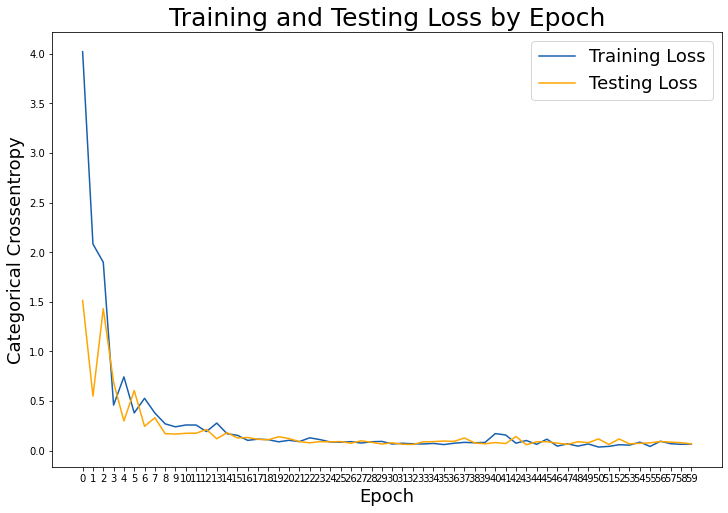

In [ ]:
train_loss = vggb_history.history['loss']
test_loss = vggb_history.history['val_loss']
epoch_labels = vggb_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

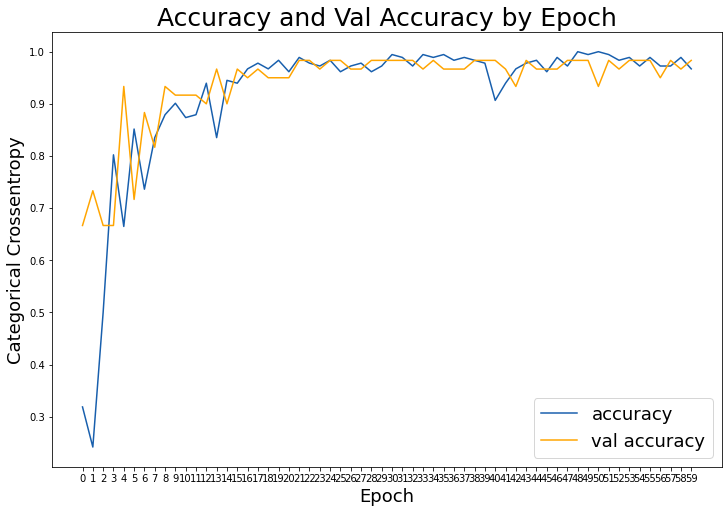

In [ ]:
train_loss = vggb_history.history['accuracy']
test_loss = vggb_history.history['val_accuracy']
epoch_labels = vggb_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='accuracy', color='#185fad')
plt.plot(test_loss, label='val accuracy', color='orange')

# Set title
plt.title('Accuracy and Val Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
vggb_model.load_weights("/content/drive/MyDrive/DSI Capstone/models/vggb_model.h5")

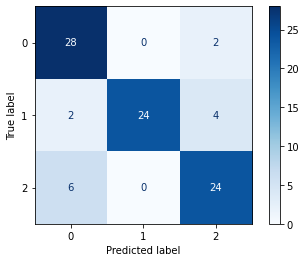

In [ ]:
vggb_preds = vggb_model.predict(test_set)
vggb_preds = np.argmax(vggb_preds,axis=1)
vggb_cm = confusion_matrix(test_set.classes, vggb_preds)
vggb_disp = ConfusionMatrixDisplay(vggb_cm);
vggb_disp.plot(cmap='Blues');

In [ ]:
vggb_model.evaluate(training_set,
                      verbose=2)

6/6 - 4s - loss: 0.0891 - accuracy: 0.9780 - 4s/epoch - 704ms/step


[0.08905977755784988, 0.9780219793319702]

In [ ]:
vggb_model.evaluate(test_set,
                      verbose=2)

90/90 - 1s - loss: 0.4432 - accuracy: 0.8444 - 1s/epoch - 17ms/step


[0.4432240426540375, 0.8444444537162781]

## VGG19 with custom layers

In [ ]:
vgg_base = VGG19(input_shape=(224, 224, 3),
                                    weights='imagenet',
                                    include_top=False)

In [ ]:
# Building a model with the pre-trained VGG19 layers
# Base layers are frozen
# Added additional layers with Dropout and BatchNormalization to reduce overfitting

vgg_model = keras.Sequential([vgg_base,
                              keras.layers.MaxPooling2D(pool_size=(2, 2)),
                              keras.layers.Flatten(),
                              keras.layers.Dense(128, activation = 'relu'),
                              keras.layers.Dropout(0.3),
                              keras.layers.BatchNormalization(),
                              keras.layers.Dense(32, activation = 'relu'),
                              keras.layers.Dense(3, activation='softmax')
                             ])

vgg_model.layers[0].trainable = False

In [ ]:
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 512)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               589952    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                        

In [ ]:
vgg_model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
vgg_history = vgg_model.fit(training_set,
                            validation_data= val_set,
                            epochs=100,
                            callbacks = cp_vgg,
                            batch_size=32,
                            )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.3539 - accuracy: 0.3297
Epoch 1: val_accuracy did not improve from 0.96667
6/6 [==============================] - 7s 1s/step - loss: 1.3539 - accuracy: 0.3297 - val_loss: 1.5953 - val_accuracy: 0.3333
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 1.2453 - accuracy: 0.3571
Epoch 2: val_accuracy did not improve from 0.96667
6/6 [==============================] - 6s 960ms/step - loss: 1.2453 - accuracy: 0.3571 - val_loss: 1.5314 - val_accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 1.1149 - accuracy: 0.4286
Epoch 3: val_accuracy did not improve from 0.96667
6/6 [==============================] - 6s 986ms/step - loss: 1.1149 - accuracy: 0.4286 - val_loss: 1.1979 - val_accuracy: 0.3500
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 1.0963 - accuracy: 0.4121
Epoch 4: val_accuracy did not improve from 0.96667
6/6 [==============================] - 6

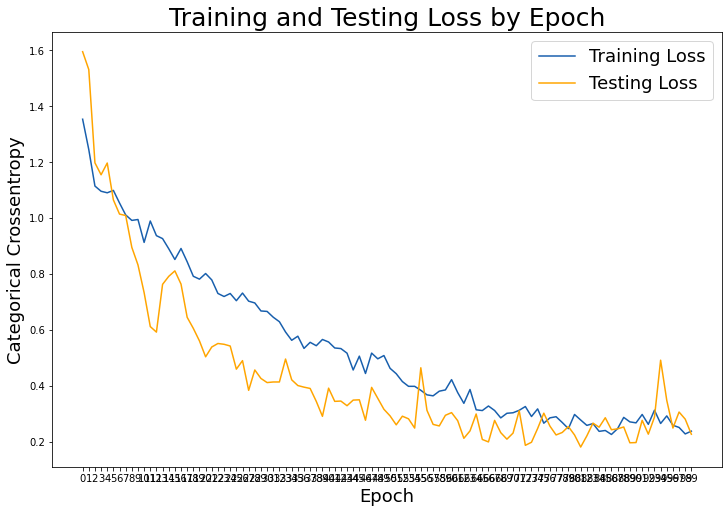

In [ ]:
train_loss = vgg_history.history['loss']
test_loss = vgg_history.history['val_loss']
epoch_labels = vgg_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

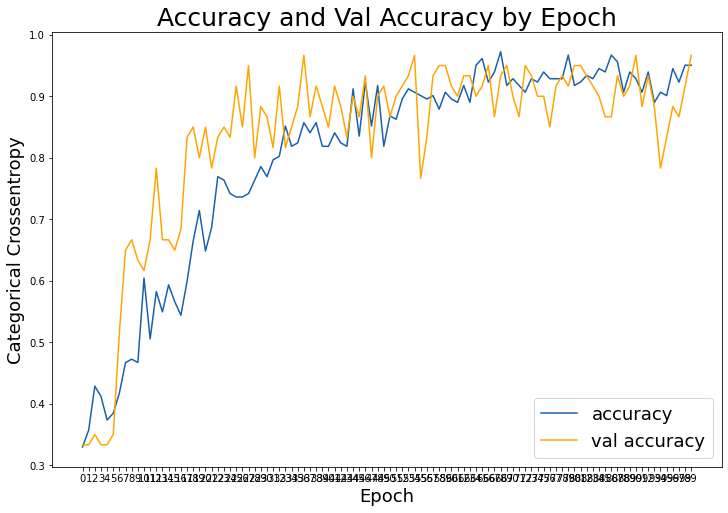

In [ ]:
train_loss = vgg_history.history['accuracy']
test_loss = vgg_history.history['val_accuracy']
epoch_labels = vgg_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='accuracy', color='#185fad')
plt.plot(test_loss, label='val accuracy', color='orange')

# Set title
plt.title('Accuracy and Val Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
vgg_model.load_weights("/content/drive/MyDrive/DSI Capstone/models/vgg_model.h5")

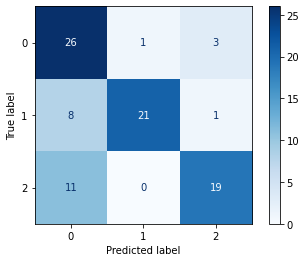

In [ ]:
vgg_preds = vgg_model.predict(test_set)
vgg_preds = np.argmax(vgg_preds,axis=1)
vgg_cm = confusion_matrix(test_set.classes, vgg_preds)
vgg_disp = ConfusionMatrixDisplay(vgg_cm);
vgg_disp.plot(cmap='Blues');

In [ ]:
vgg_model.evaluate(training_set,
                      verbose=2)

6/6 - 5s - loss: 0.3201 - accuracy: 0.9066 - 5s/epoch - 764ms/step


[0.3200501799583435, 0.906593382358551]

In [ ]:
vgg_model.evaluate(test_set,
                      verbose=2)

90/90 - 1s - loss: 0.5852 - accuracy: 0.7333 - 1s/epoch - 16ms/step


[0.5851508378982544, 0.7333333492279053]

## MobileNet Base Only

In [1]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [3]:
mobile_base = MobileNet(weights='imagenet',
                        include_top= False,
                        input_shape=((224, 224, 3)))

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# Building a model with the pre-trained MobileNet layers
# Base layers are frozen

mobileb_model = keras.Sequential([mobile_base,
                                  keras.layers.Flatten(),
                                  keras.layers.Dense(3, activation='softmax')
                                 ])

mobileb_model.layers[0].trainable = False

In [ ]:
mobileb_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 dense_8 (Dense)             (None, 3)                 150531    
                                                                 
Total params: 3,379,395
Trainable params: 150,531
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
mobileb_model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
mb_history = mobileb_model.fit(training_set, 
                        batch_size=32,
                        validation_data = val_set,
                        callbacks = cp_mobileb,
                        epochs=60,
                        verbose=1)

Epoch 1/60
6/6 [==============================] - ETA: 0s - loss: 23.0927 - accuracy: 0.1538
Epoch 1: val_accuracy did not improve from 1.00000
6/6 [==============================] - 8s 1s/step - loss: 23.0927 - accuracy: 0.1538 - val_loss: 13.6141 - val_accuracy: 0.6667
Epoch 2/60
6/6 [==============================] - ETA: 0s - loss: 5.5434 - accuracy: 0.7582
Epoch 2: val_accuracy did not improve from 1.00000
6/6 [==============================] - 5s 937ms/step - loss: 5.5434 - accuracy: 0.7582 - val_loss: 2.8185 - val_accuracy: 0.6667
Epoch 3/60
6/6 [==============================] - ETA: 0s - loss: 1.8643 - accuracy: 0.7692
Epoch 3: val_accuracy did not improve from 1.00000
6/6 [==============================] - 5s 946ms/step - loss: 1.8643 - accuracy: 0.7692 - val_loss: 0.2313 - val_accuracy: 0.9500
Epoch 4/60
6/6 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.9176
Epoch 4: val_accuracy did not improve from 1.00000
6/6 [==============================] - 5s

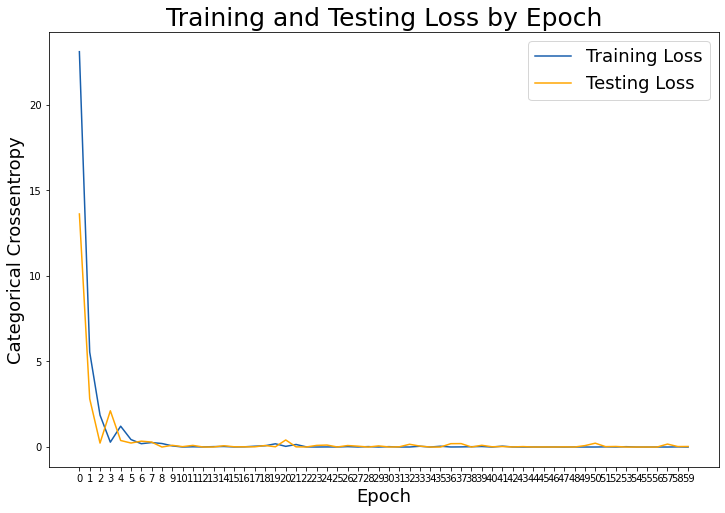

In [ ]:
train_loss = mb_history.history['loss']
test_loss = mb_history.history['val_loss']
epoch_labels = mb_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

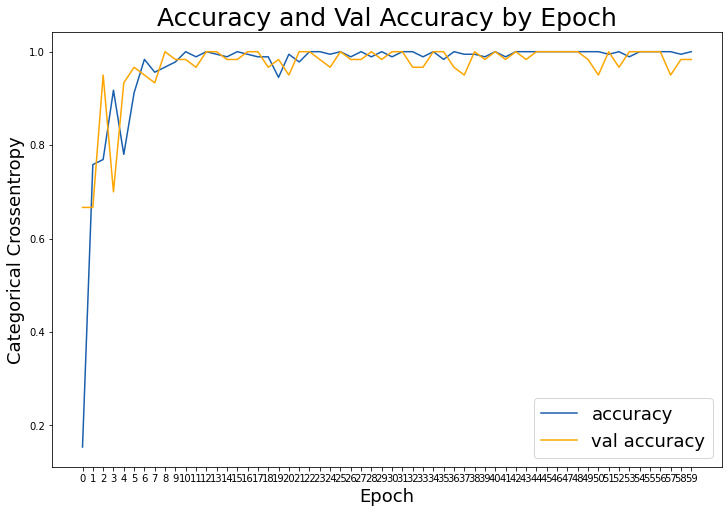

In [ ]:
train_loss = mb_history.history['accuracy']
test_loss = mb_history.history['val_accuracy']
epoch_labels = mb_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='accuracy', color='#185fad')
plt.plot(test_loss, label='val accuracy', color='orange')

# Set title
plt.title('Accuracy and Val Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
mobileb_model.load_weights("/content/drive/MyDrive/DSI Capstone/models/mobile_model.h5")

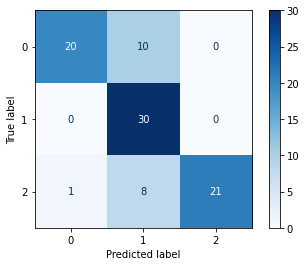

In [ ]:
mb_preds = mobileb_model.predict(test_set)
mb_preds = np.argmax(mb_preds,axis=1)
mb_cm = confusion_matrix(test_set.classes, mb_preds)
mb_disp = ConfusionMatrixDisplay(mb_cm);
mb_disp.plot(cmap='Blues');

In [ ]:
mobileb_model.evaluate(training_set,
                      verbose=2)

6/6 - 5s - loss: 0.0251 - accuracy: 0.9945 - 5s/epoch - 815ms/step


[0.025114258751273155, 0.9945054650306702]

In [ ]:
mobileb_model.evaluate(test_set,
                      verbose=2)

90/90 - 1s - loss: 12.2197 - accuracy: 0.7889 - 1s/epoch - 16ms/step


[12.219704627990723, 0.7888888716697693]

## MobileNet Plus Custom Layers

In [ ]:
# Building a model with the pre-trained MobileNet layers
# Base layers are frozen
# Added additional layers with Dropout and BatchNormalization to reduce overfitting

mobile_model = keras.Sequential([mobile_base,
                              keras.layers.MaxPooling2D(pool_size=(2, 2)),
                              keras.layers.Flatten(),
                              keras.layers.Dense(128, activation = 'relu'),
                              keras.layers.Dropout(0.3),
                              keras.layers.BatchNormalization(),
                              keras.layers.Dense(32, activation = 'relu'),
                              keras.layers.Dense(3, activation='softmax')
                             ])

mobile_model.layers[0].trainable = False

In [ ]:
mobile_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 9216)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               1179776   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)             

In [ ]:
mobile_model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
m_history = mobile_model.fit(training_set, 
                        batch_size=32,
                        validation_data = val_set,
                        callbacks = cp_mobile,
                        epochs=100,
                        verbose=1)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.3352 - accuracy: 0.3681
Epoch 1: val_accuracy did not improve from 1.00000
6/6 [==============================] - 8s 1s/step - loss: 1.3352 - accuracy: 0.3681 - val_loss: 3.8387 - val_accuracy: 0.3667
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 1.0710 - accuracy: 0.4615
Epoch 2: val_accuracy did not improve from 1.00000
6/6 [==============================] - 6s 991ms/step - loss: 1.0710 - accuracy: 0.4615 - val_loss: 0.7883 - val_accuracy: 0.6833
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 1.1010 - accuracy: 0.5220
Epoch 3: val_accuracy did not improve from 1.00000
6/6 [==============================] - 6s 963ms/step - loss: 1.1010 - accuracy: 0.5220 - val_loss: 0.4665 - val_accuracy: 0.7333
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 1.0036 - accuracy: 0.5000
Epoch 4: val_accuracy did not improve from 1.00000
6/6 [==============================] - 5

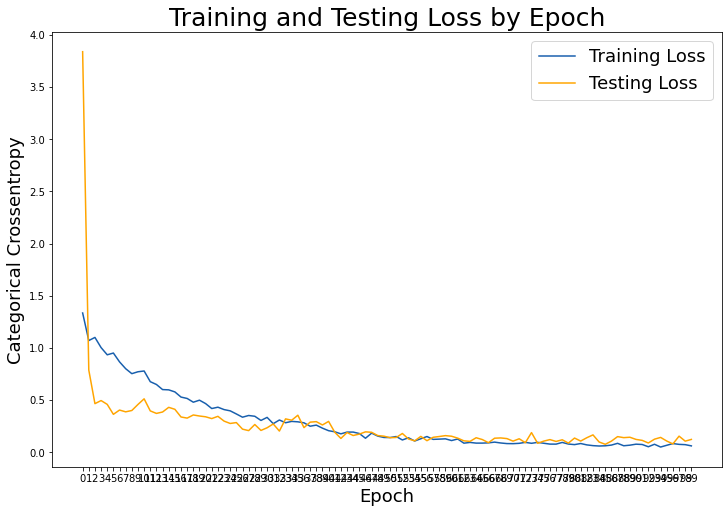

In [ ]:
train_loss = m_history.history['loss']
test_loss = m_history.history['val_loss']
epoch_labels = m_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

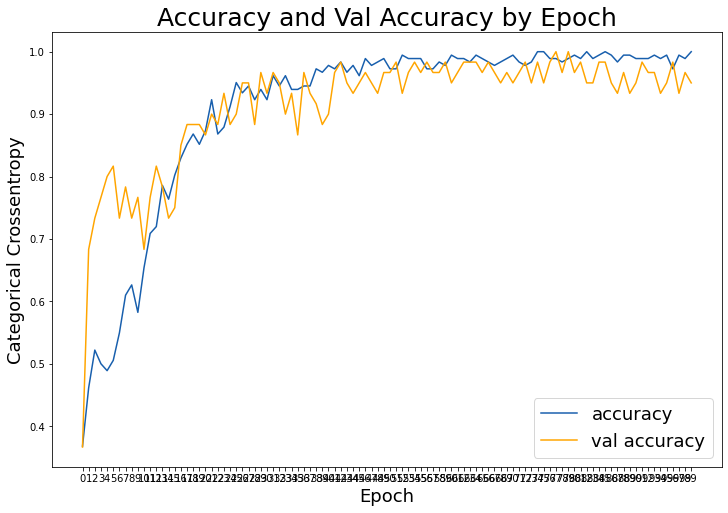

In [ ]:
train_loss = m_history.history['accuracy']
test_loss = m_history.history['val_accuracy']
epoch_labels = m_history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='accuracy', color='#185fad')
plt.plot(test_loss, label='val accuracy', color='orange')

# Set title
plt.title('Accuracy and Val Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [ ]:
mobile_model.load_weights("/content/drive/MyDrive/DSI Capstone/models/mobile_model.h5")

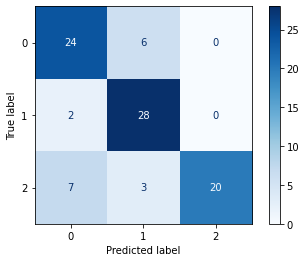

In [ ]:
m_preds = mobile_model.predict(test_set)
m_preds = np.argmax(m_preds,axis=1)
m_cm = confusion_matrix(test_set.classes, m_preds)
m_disp = ConfusionMatrixDisplay(m_cm);
m_disp.plot(cmap='Blues');

In [ ]:
mobile_model.evaluate(training_set,
                      verbose=2)

6/6 - 5s - loss: 0.1059 - accuracy: 0.9890 - 5s/epoch - 805ms/step


[0.10586048662662506, 0.9890109896659851]

In [ ]:
mobile_model.evaluate(test_set,
                      verbose=2)

90/90 - 1s - loss: 0.5620 - accuracy: 0.8000 - 1s/epoch - 16ms/step


[0.5619972348213196, 0.800000011920929]

## Summary of Models and Performance 

After constructing and evaluating the five models, their performance are compiled and compared in the table below:
<br/>
<br/>

|   |     **Model**    | **Train Acc** | **Train Loss** | **Test Acc** | **Test Loss** |
|:-:|:----------------:|:-------------:|----------------|:------------:|:-------------:|
| 1 |    Custom CNN    |     0.8571    |     0.4086     |    0.5889    |     1.1550    |
| 2 |    VGG19 Base    |     0.9780    |     0.0891     |  **0.8444**  |   **0.4432**  |
| 3 |   VGG19 Custom   |     0.9066    |     0.3201     |    0.7333    |     0.5852    |
| 4 |  MobileNet Base  |     0.9945    |     0.0251     |    0.7889    |    12.2197    |
| 5 | MobileNet Custom |     0.9890    |     0.1059     |    0.8000    |     0.5620    |


<br/>
<br/>
With reference to the table above, we can conclude the the VGG19 Base model is the best among the five as it scores the highest in terms of accuracy on unseen test data.

# Misclassification Analysis

In [ ]:
training_set.class_indices

{'daoguang': 0, 'guangxu': 1, 'qianlong': 2}

In [ ]:
vggb_predict_label = []

for i in vggb_preds:
  if i == 0:
    vggb_predict_label.append("Daoguang")
  elif i == 1:
    vggb_predict_label.append("Guangxu")
  else:
    vggb_predict_label.append("Qianlong")

In [ ]:
test_set_label = []

for i in test_set.classes:
  if i == 0:
    test_set_label.append("Daoguang")
  elif i == 1:
    test_set_label.append("Guangxu")
  else:
    test_set_label.append("Qianlong")

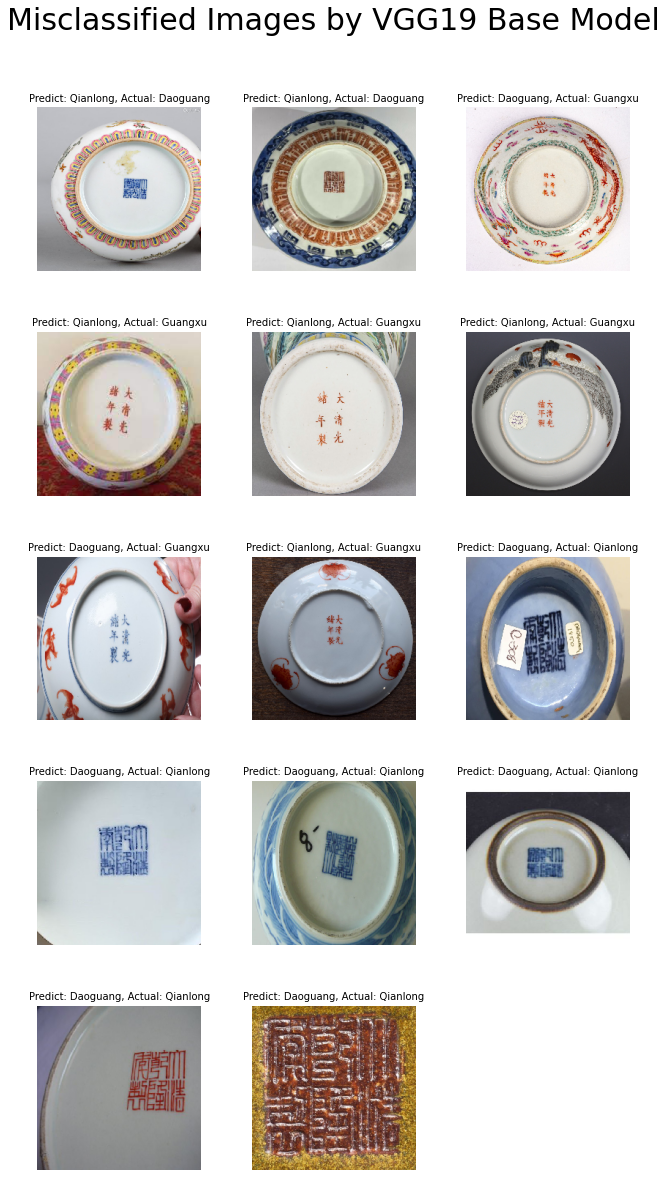

In [ ]:
misclassindex = np.where(test_set.classes!=vggb_preds)[0]
fig, ax = plt.subplots(5, 3, figsize=(9,16))
plt.suptitle('Misclassified Images by VGG19 Base Model', fontsize = 30, y = 1.05)
ax = ax.ravel()
for i, misclass in enumerate(misclassindex):
    ax[i].imshow(np.reshape(test_set[misclass][0][0], (224, 224, 3)))
    ax[i].set_title(f'Predict: {vggb_predict_label[misclass]}, '
                    f'Actual: {test_set_label[misclass]}', fontsize = 10)
    ax[i].set(frame_on=True)
    ax[i].axis('off')
plt.box(False)
plt.tight_layout()
plt.axis('off');


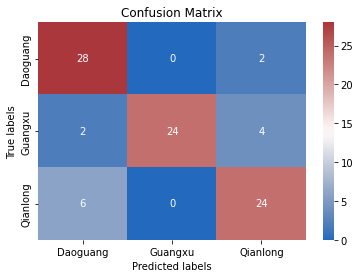

In [ ]:
import seaborn as sns

cm = confusion_matrix(test_set_label, vggb_predict_label)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="vlag");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Daoguang', 'Guangxu', 'Qianlong']); ax.yaxis.set_ticklabels(['Daoguang', 'Guangxu', 'Qianlong']);

When we examine the misclassified images from our choice VGG19 Base model, we can observed that out of the 14 missclassified images, 13 belong the group of "dirty" test images that have not been cropped and processed to just show the mark.
<br/>

The single "clean" test image that was misclassified belongs to the "Qianlong" class which looks very similar to the "Daoguang" mark as they are both in "Zhuanshu" format.

# Prediction with Clean Images

Before concluding the project, we will test the model using a clean dataset. The "dirty" images from the previous test set has been cropped to ensure the porcelain mark is centrally located and can be clearly identified.

In [ ]:
#try final model on cleaned test image
test_set_clean = test_datagen.flow_from_directory(test_path_clean,
                                             target_size = (224, 224),
                                             batch_size = 1,
                                            shuffle = False,
                                            class_mode = 'categorical')


Found 90 images belonging to 3 classes.


In [ ]:
vggb_predict_label = []

for i in vggb_preds:
  if i == 0:
    vggb_predict_label.append("Daoguang")
  elif i == 1:
    vggb_predict_label.append("Guangxu")
  else:
    vggb_predict_label.append("Qianlong")

In [ ]:
test_set_label = []

for i in test_set_clean.classes:
  if i == 0:
    test_set_label.append("Daoguang")
  elif i == 1:
    test_set_label.append("Guangxu")
  else:
    test_set_label.append("Qianlong")

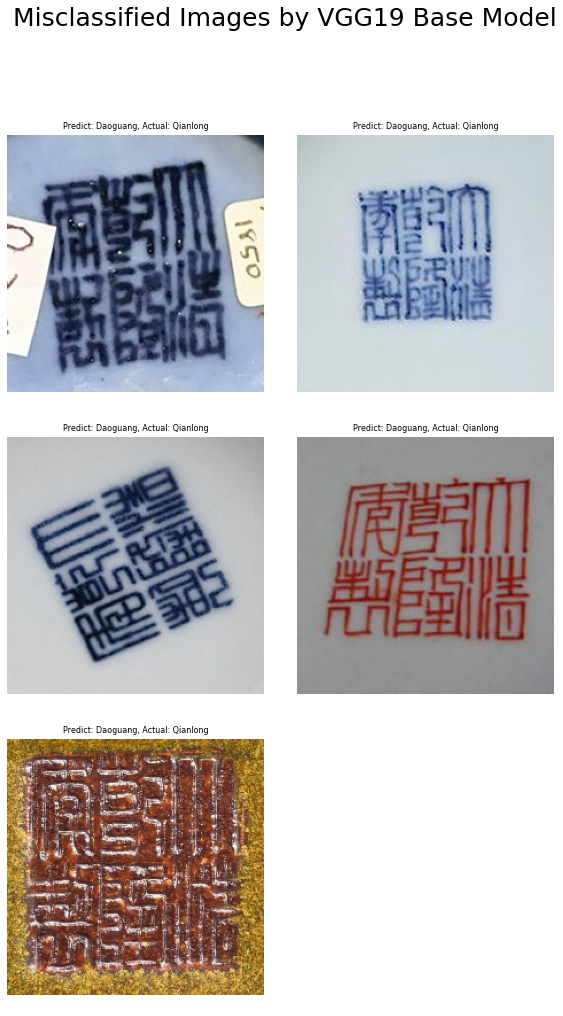

In [ ]:
misclassindex = np.where(test_set_clean.classes!=vggb_preds)[0]
fig, ax = plt.subplots(3, 2, figsize=(8,13))
plt.suptitle('Misclassified Images by VGG19 Base Model', fontsize = 25, y = 1.1)
ax = ax.ravel()
for i, misclass in enumerate(misclassindex):
    ax[i].imshow(np.reshape(test_set_clean[misclass][0][0], (224, 224, 3)))
    ax[i].set_title(f'Predict: {vggb_predict_label[misclass]}, '
                    f'Actual: {test_set_label[misclass]}', fontsize = 8)
    ax[i].set(frame_on=True)
    ax[i].axis('off')
plt.box(False)
plt.tight_layout()
plt.axis('off');

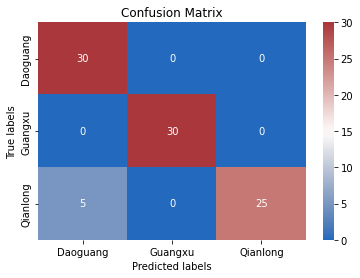

In [ ]:
cm = confusion_matrix(test_set_label, vggb_predict_label)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="vlag");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Daoguang', 'Guangxu', 'Qianlong']); ax.yaxis.set_ticklabels(['Daoguang', 'Guangxu', 'Qianlong']);

In [ ]:
vggb_model.evaluate(test_set_clean,
                      verbose=2)

90/90 - 1s - loss: 0.1147 - accuracy: 0.9444 - 1s/epoch - 14ms/step


[0.11473417282104492, 0.9444444179534912]

**Accuracy Improved from 84% to 94%**
<br/>

As expected, with a cleaner dataset, we see a huge improvement in the classification accuracy from 84% to 94%. The misclassification also occurs where it is more likely, which is between the "Daoguang" and "Qianlong" class. All "Guangxu" class images have been classified accurately and only 5 "Qianlong" marks were wrongly classified as "Daoguang" marks. Then model behave similarly to when it was predicting on the unclean data where it seems to have a bias towards classifying "Daoguang" marks.
<br/>

When examining the misclassified images, again 4 of the 5 images originated from the "dirty" images, albiet cleaning has been done. The same clean image that has been misclassified is again being misclassified here. For the four misclassified images, we can see that the marks are more rotated, skewed or had sticker covering part of the mark. All these factor may have contributed to the misclassification.

# Conclusion and Future Works

**Conclusion**
<br/>

In conclusion, an experimental Chinese porcelain mark classifier capable of classifying 3 different porcelain marks from the Qing dynasty have been successfully modelled. While the model has an accuracy of 84%, it is acknowledged that it does struggles more with dirty images where the image of the porcelain mark itself do not occupy the majority of the image space. Nonethless, this project will therefore serve as a great base for further enhancement and improvement which will be discussed in the future works section.

**Future Works**
<br/>

As exhibited by the 10% increase in accuracy when the model is required to classify only clean images, the weakness of the model is in making the classification when there is too much noise in the image. One possibile way to counter this problem is to include an **object detection** function in the model. If the object detection is implemented properly, the classifier will only consider portion of image that it recognises as a porcelain mark. Which means the model will be less affected by noisy image data.

<br/>

Another area to expand the dimension of the project will be to **add more classes** of porcelain marks. We can start by including all the 10 important reign marks of the Qing Dynasty. Each reign mark can be found in either Zhuanshu or Kaishu which expands it into a 20-class classificaiton model. An expended model that can handle most of the important reign marks of Qing Dynasty will definitely be more beneficial for budding collectors and therefore attract them to use it.

<br/>

The final goal is to **deploy the classifier** on the website of East Inspirations as a way to engage customers who are interested chinese antique porcelain. Visitors of the website can submit an image of the porcelain mark they have and our model will be able tell them which reign mark it most likely is. Images submitted by the users can also be collected to add into our train data set to improve it's performance.This will hopefully help drive traffic to the website and increase awareness of our local business. 

